<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exercise/%F0%9F%9B%A0_09_Milestone_Project_2_SkimLit_%F0%9F%93%84%F0%9F%94%A5_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 09. Milestone Project 2: SkimLit 📄🔥 Exercise Solutions.

> **Note** The orders of the exercise is mixed. 


1. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  - Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  - It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

2. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?

  - Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  - Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf. 

3. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  - Another example: `line_number=1` and total_lines=11 turns into `line_of_X=1_of_11`.

4. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  - `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.
  - `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
```
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
```
You can find your own unstrcutured RCT abstract from PubMed or try this one from: [Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection.](https://pubmed.ncbi.nlm.nih.gov/22244707/)

## Downloading the data and preprocessing it. 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers 

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [7]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 488 ms, sys: 107 ms, total: 595 ms
Wall time: 595 ms


In [8]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [9]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [10]:
# One hot encoding the labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
# Extract labels and encoder them into integers 
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder() 

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [12]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))


### 1. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?

In [13]:
# Loading the pre-trained embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-09-11 22:38:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-11 22:38:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-11 22:38:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
# Getting the path of the glove embedding (using 100D)
import numpy as np 
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:
    
    # Getting the words and coef in a variable 
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')
    
    # Adding the coefs to our embedding dict 
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


Great we loaded in the data and the next step will be creating a corresponding embedding matrix. So we can fit our `embedding_index` to our Embedding layer. 


In [15]:
# Getting the sentences and characters 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]


In [16]:
# Creatinga a text vectorizaiton layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization 

text_vectorizer = TextVectorization(max_tokens= 68000 , 
                                    output_sequence_length = 56)

# Adapt our text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [17]:
# Getting the vocabulary of the vectorizer 
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [18]:
# Getting the dict mapping word --> index 
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

In [21]:
# Creating a function that will give us a embedding matrix 
def get_glove_embedding_matrix(num_tokens , embedding_dim , word_index):

  # Defining the hits and misses here 
  hits , misses = 0 , 0

  # Prepare the embedding matrix 
  embedding_matrix = np.zeros((num_tokens , embedding_dim ))
  for word , i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 
      hits += 1 
    else:
      misses += 1 

  return embedding_matrix , hits , misses

In [22]:
# Using the above function to get the embedding matrix 

num_tokens_text = len(text_vocab) + 2 
embedding_dim = 100

sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)



print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [23]:
# Adding the embedding matrix to our Embedding layer (Sentence and characters)
from tensorflow.keras.layers import Embedding

sen_embedding_layer = Embedding(num_tokens_text , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                            trainable = False )


Before making the datasets, we gotta convert our string's into numerical values with the help of the `vectorizer` layers we have created for our both sentence and characters.

In [24]:
# Creating the datasets for our both sentences and chars  

train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

# Training and validation dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoded))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoded))


# Applying the batch size and prefetching (performance optimization )
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


train_ds,  val_ds

(<PrefetchDataset shapes: ((None, 56), (None,)), types: (tf.int64, tf.int64)>,
 <PrefetchDataset shapes: ((None, 56), (None,)), types: (tf.int64, tf.int64)>)

Perfect! Now we're gonna build a model that will use glove embeddings as the core.

In [25]:
train_sen_vectors[0].shape

(56,)

In [26]:
# Sample 
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model = tf.keras.Model(input , output)
glove_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         6484300   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

Now we gotta convert our list of string data to Numpy arrays of integer indicees. Th

In [27]:
# Compiling and fitting the model
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

glove_model.fit(train_ds,
                 epochs = 3 , 
                 validation_data = val_ds)

Epoch 1/3
5627/5627 [==============================] - 69s 7ms/step - loss: 0.6510 - accuracy: 0.7582 - val_loss: 0.5520 - val_accuracy: 0.7943
Epoch 2/3
5627/5627 [==============================] - 42s 8ms/step - loss: 0.5284 - accuracy: 0.8078 - val_loss: 0.5169 - val_accuracy: 0.8109
Epoch 3/3
5627/5627 [==============================] - 42s 7ms/step - loss: 0.4830 - accuracy: 0.8242 - val_loss: 0.5294 - val_accuracy: 0.8135


### 2. PubMed Bert 


In [28]:
# Download by uncommenting the below command
!pip install tensorflow_text 

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [29]:
# Loading in the both encoder and the preprocessing models 
import tensorflow_text as text
import tensorflow_hub as hub

# preprocess_bert = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
# bert = hub.load('')

preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' ,
                                     trainable = False , name = 'pubmed_bert_preprocessor')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2' ,
                            trainable = False , 
                            name = 'bert_model_layer')

In [30]:
# Creating a model out of it 
input = layers.Input(shape = [] , dtype = tf.string , name = 'input_sentences')
bert_inputs = preprocessing_layer(input)
bert_embedding =bert_layer(bert_inputs)
print(f'bert embedding shape: {bert_embedding}')
##x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(bert_embedding['pooled_output'])
x = layers.Dense(128 , activation = 'relu')(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

# Packing into a model
pubmed_bert_model = tf.keras.Model(input , output)
pubmed_bert_model.summary()

bert embedding shape: {'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=floa

In [31]:
# Making datasets for the pubmed model

train_sen_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
train_sen_ds = train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_sen_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
val_sen_ds = val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
pubmed_bert_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                          optimizer = tf.keras.optimizers.Adam(), 
                          metrics =['accuracy'])

pubmed_bert_model.fit(train_sen_ds ,
                      steps_per_epoch = int(0.1 * len(train_sen_ds)),
                      epochs = 3 , 
                      validation_data = val_sen_ds , 
                      validation_steps = int(0.1 * len(val_sen_ds)))

Epoch 1/3
562/562 [==============================] - 432s 750ms/step - loss: 0.6410 - accuracy: 0.7789 - val_loss: 0.4614 - val_accuracy: 0.8361
Epoch 2/3
562/562 [==============================] - 420s 748ms/step - loss: 0.5197 - accuracy: 0.8195 - val_loss: 0.4484 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 420s 748ms/step - loss: 0.5009 - accuracy: 0.8255 - val_loss: 0.4161 - val_accuracy: 0.8567


### 3 : Creating new function 


In [46]:
# Combining the total lines and line number into a new feature! 
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [60]:
# Perform one hot encoding on the train and transform the validation dataframe 
from sklearn.preprocessing import OneHotEncoder

# Creating an instance 
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe 
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df 
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))

# Checking the shapes 
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [61]:
# Converting the sparse object to array 
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()

# Converting the datatype to int 
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)

Now lets build a tribid model which use pubmed Bert as the embedding and model + our new `line_number_total` feature which is the combination of `line_number` and `total_lines`. 



In [69]:
# Making the performant datasets for our tribid model 
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars , 
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences , 
                                               val_chars , 
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)

# Zipping the data and labels 
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))

# Applying batch and prefetching 
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<PrefetchDataset shapes: (((None,), (None,), (None, 460)), (None,)), types: ((tf.string, tf.string, tf.int32), tf.int64)>,
 <PrefetchDataset shapes: (((None,), (None,), (None, 460)), (None,)), types: ((tf.string, tf.string, tf.int32), tf.int64)>)

In [70]:
# Buidling the tribid model 

input_token = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_token = preprocessing_layer(input_token)
bert_embedding_char =bert_layer(bert_inputs_token)
output_token = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
token_model = tf.keras.Model(input_token , output_token)

input_char = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char =bert_layer(bert_inputs_char)
output_char = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
char_model = tf.keras.Model(input_char , output_char)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output , 
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output , 
                                                    combined_embeddings])

# Adding a dense + dropout and creating our output layer 
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128 , activation='relu')(dropout)
output_layer = layers.Dense(5 , activation='softmax')(x)

# Packing into a model
tribid_model = tf.keras.Model(inputs = [token_model.input , 
                                        char_model.input , 
                                        total_line_number_model.input] , 
                              outputs = output_layer)

tribid_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
pubmed_bert_preprocessor (Keras {'input_word_ids': ( 0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
bert_model_layer (KerasLayer)   {'encoder_outputs':  109482241   pubmed_bert_preprocessor[5

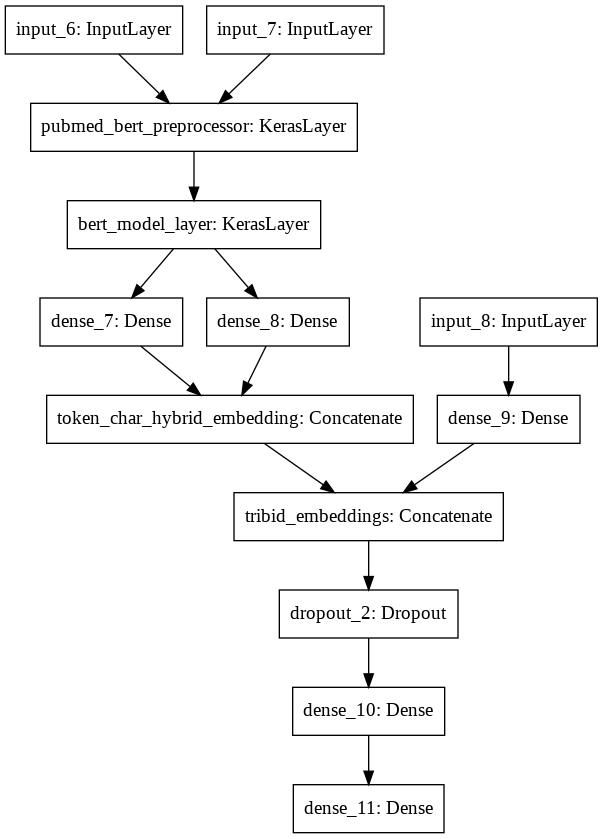

In [66]:
# Plotting the model structure 
from tensorflow.keras.utils import plot_model
plot_model(tribid_model)

In [71]:
# Compiling and fitting the model (Fun Part!)
tribid_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
                     optimizer= tf.keras.optimizers.Adam() , 
                     metrics = ['accuracy'])

# Fitting the model for fewer epochs  (training only on 10% of the data)
# To speed up the experimentation

tribid_model.fit(train_dataset , 
                 steps_per_epoch = int(0.1 * len(train_dataset)), 
                 epochs = 3 , 
                 validation_steps = int(0.1 * len(val_dataset)),
                 validation_data = val_dataset)

Epoch 1/3
281/281 [==============================] - 863s 3s/step - loss: 0.7086 - accuracy: 0.7498 - val_loss: 0.4427 - val_accuracy: 0.8421
Epoch 2/3
281/281 [==============================] - 857s 3s/step - loss: 0.4773 - accuracy: 0.8322 - val_loss: 0.3641 - val_accuracy: 0.8494
Epoch 3/3
281/281 [==============================] - 856s 3s/step - loss: 0.4101 - accuracy: 0.8564 - val_loss: 0.3330 - val_accuracy: 0.8813


In [72]:
# Evaluating on the whole val data 
tribid_model.evaluate(val_dataset)

473/473 [==============================] - 1233s 3s/step - loss: 0.3193 - accuracy: 0.8822


[0.3193438947200775, 0.8822322487831116]

### 4. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. 

In [77]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), TensorShape([180040, 15]))

In [89]:
# Re-building the Model 5 

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)


# 2. Char inputs
char_inputs = layers.Input(shape= [], dtype="string", name="char_inputs")
char_embeddings = tf_hub_embedding_layer(char_inputs)
exp_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(exp_layer)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)



# Summary of the model 
model_5.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
                                                                 char_inputs[0][0]                
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1, 512)       0           universal_sentence_encoder

In [85]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

`tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.

`tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.


In [86]:
# Creating the callbacks 
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath , 
                                                               save_weights_only = True , 
                                                               save_best_only = True  , 
                                                               save_freq = 'epoch' , 
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

Now while compile and fit the data on 100% of the training data. 

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['accuracy'])

history = model_5.fit(train_pos_char_token_dataset , 
                      epochs = 100 , 
                      validation_data = val_pos_char_token_dataset  , 
                      callbacks = [early_stopping , model_checkpoint_callback , 
                                   reduce_lr])

Epoch 1/100
5627/5627 [==============================] - 291s 51ms/step - loss: 0.9706 - accuracy: 0.8139 - val_loss: 0.9244 - val_accuracy: 0.8427
Epoch 2/100
5627/5627 [==============================] - 284s 50ms/step - loss: 0.9313 - accuracy: 0.8435 - val_loss: 0.9124 - val_accuracy: 0.8513
Epoch 3/100
5627/5627 [==============================] - 283s 50ms/step - loss: 0.9228 - accuracy: 0.8502 - val_loss: 0.9095 - val_accuracy: 0.8549
Epoch 4/100
5627/5627 [==============================] - 284s 50ms/step - loss: 0.9182 - accuracy: 0.8533 - val_loss: 0.9052 - val_accuracy: 0.8598
Epoch 5/100
5627/5627 [==============================] - 284s 51ms/step - loss: 0.9142 - accuracy: 0.8578 - val_loss: 0.9048 - val_accuracy: 0.8592
Epoch 6/100
5627/5627 [==============================] - 285s 51ms/step - loss: 0.9102 - accuracy: 0.8601 - val_loss: 0.9039 - val_accuracy: 0.8593
Epoch 7/100
5627/5627 [==============================] - 284s 50ms/step - loss: 0.9078 - accuracy: 0.8631 - val_